In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import numpy as np 
import datetime
import math
import rick
import geopandas as gpd
import os
import shapely
from shapely.geometry import Point
#os.environ["PROJ_LIB"]=r"C:\Users\rliu4\AppData\Local\Continuum\anaconda3\Library\share"
import importlib
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
CONFIG = configparser.ConfigParser()
CONFIG.read('/home/rliu/bdit_vfh/config.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [2]:
mpl.rcParams['figure.dpi'] = 450

In [3]:
query = '''

WITH sum AS (
SELECT extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr, extract(week from pickup_datetime) as wk, pickup_neighbourhood, 
sum(count) as count  FROM ptc.trip_data_agg_neighbourhood
GROUP BY   pickup_datetime, pickup_neighbourhood

), ward1 AS  (

SELECT  avg(count) as count, pickup_neighbourhood from sum
WHERE (yr=2018 AND mon IN (9))
GROUP BY pickup_neighbourhood
ORDER BY count
), ward2 AS  (

SELECT avg(count) as count, pickup_neighbourhood from sum
WHERE (yr=2016 AND mon IN (10))
GROUP BY pickup_neighbourhood
ORDER BY count
)

SELECT pickup_neighbourhood,  geom, (b.count - a.count)/(a.count)*100 as growth FROM ward2 a 
LEFT JOIN ward1 b USING ( pickup_neighbourhood)
LEFT JOIN gis.neighbourhood ON area_s_cd::integer=pickup_neighbourhood

'''

data = gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
data = data.to_crs({'init' :'epsg:3857'})

for index, row in data.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    data.at[index, 'geom'] = rotated

In [4]:
data=data[['geom', 'growth']]

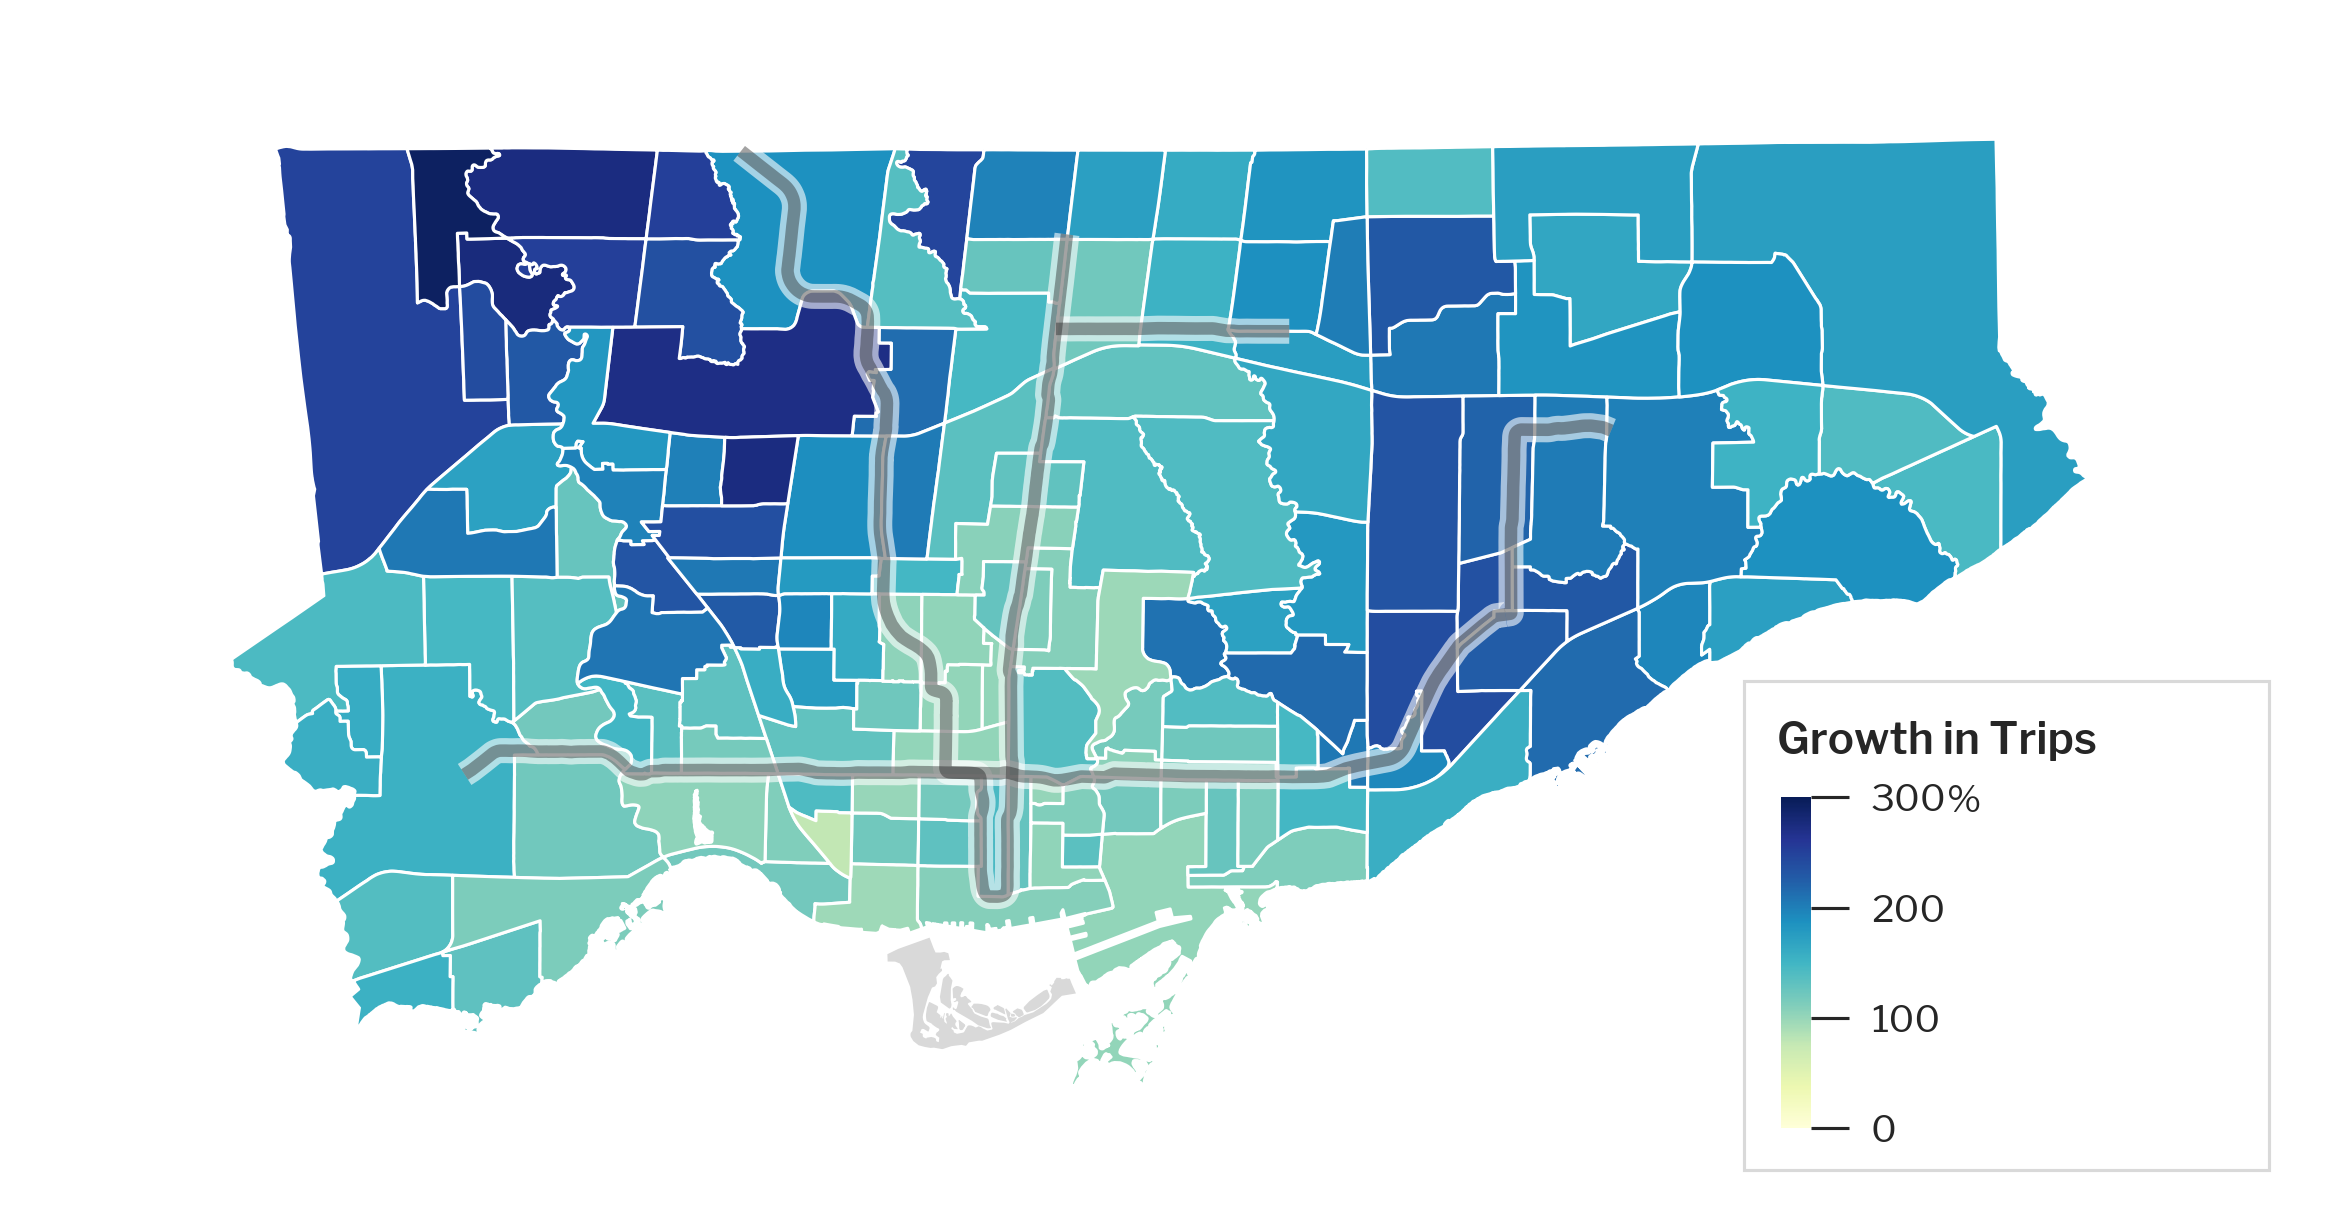

In [5]:
fig, ax = rick.charts.chloro_map(con, data, subway = True, lower = 0, upper = 300, title = 'Growth in Trips', 
                                       island = False, cmap = 'YlGnBu', unit = '%', nbins = 3)

In [6]:
query='''
WITH daily_ave AS (

SELECT * FROM ptc.daily_trips
), total AS  (
SELECT  extract(month from pickup_datetime) as mon,
extract(year from pickup_datetime) as yr,

CASE WHEN extract(year from pickup_datetime) = 2018 AND extract(month from pickup_datetime) IN (3) THEN 108321
WHEN extract(year from pickup_datetime) = 2018 AND extract(month from pickup_datetime) IN (11) THEN 161733 ELSE
avg(count)::integer END as count FROM daily_ave
GROUP BY extract(month from pickup_datetime), extract(year from pickup_datetime)
ORDER BY extract(year from pickup_datetime), extract(month from pickup_datetime)
)


SELECT 
CASE WHEN mon = 1 THEN to_char(to_timestamp (mon::text, 'MM'), 'Mon')||' '||yr::text 
WHEN mon = 9 AND yr = 2016 THEN to_char(to_timestamp (mon::text, 'MM'), 'Mon')||' '||yr::text 
ELSE to_char(to_timestamp (mon::text, 'MM'), 'Mon')
END AS period, 
count FROM total
'''
total=pandasql.read_sql(query, con)

In [7]:
query='''
WITH daily_ave AS (

SELECT * FROM ptc.daily_trips
), total AS  (
SELECT  extract(month from pickup_datetime) as mon,
extract(year from pickup_datetime) as yr,

CASE WHEN extract(year from pickup_datetime) = 2018 AND extract(month from pickup_datetime) IN (3) THEN 108321
WHEN extract(year from pickup_datetime) = 2018 AND extract(month from pickup_datetime) IN (11) THEN 161733 ELSE
avg(count)::integer END as count FROM daily_ave
GROUP BY extract(month from pickup_datetime), extract(year from pickup_datetime)
ORDER BY extract(year from pickup_datetime), extract(month from pickup_datetime)
)


SELECT 
CASE WHEN mon = 1 THEN to_char(to_timestamp (mon::text, 'MM'), 'Mon')||' '||yr::text 
WHEN mon = 9 AND yr = 2016 THEN to_char(to_timestamp (mon::text, 'MM'), 'Mon')||' '||yr::text 
ELSE to_char(to_timestamp (mon::text, 'MM'), 'Mon')
END AS period, 
count/2 as count FROM total
'''
total2=pandasql.read_sql(query, con)

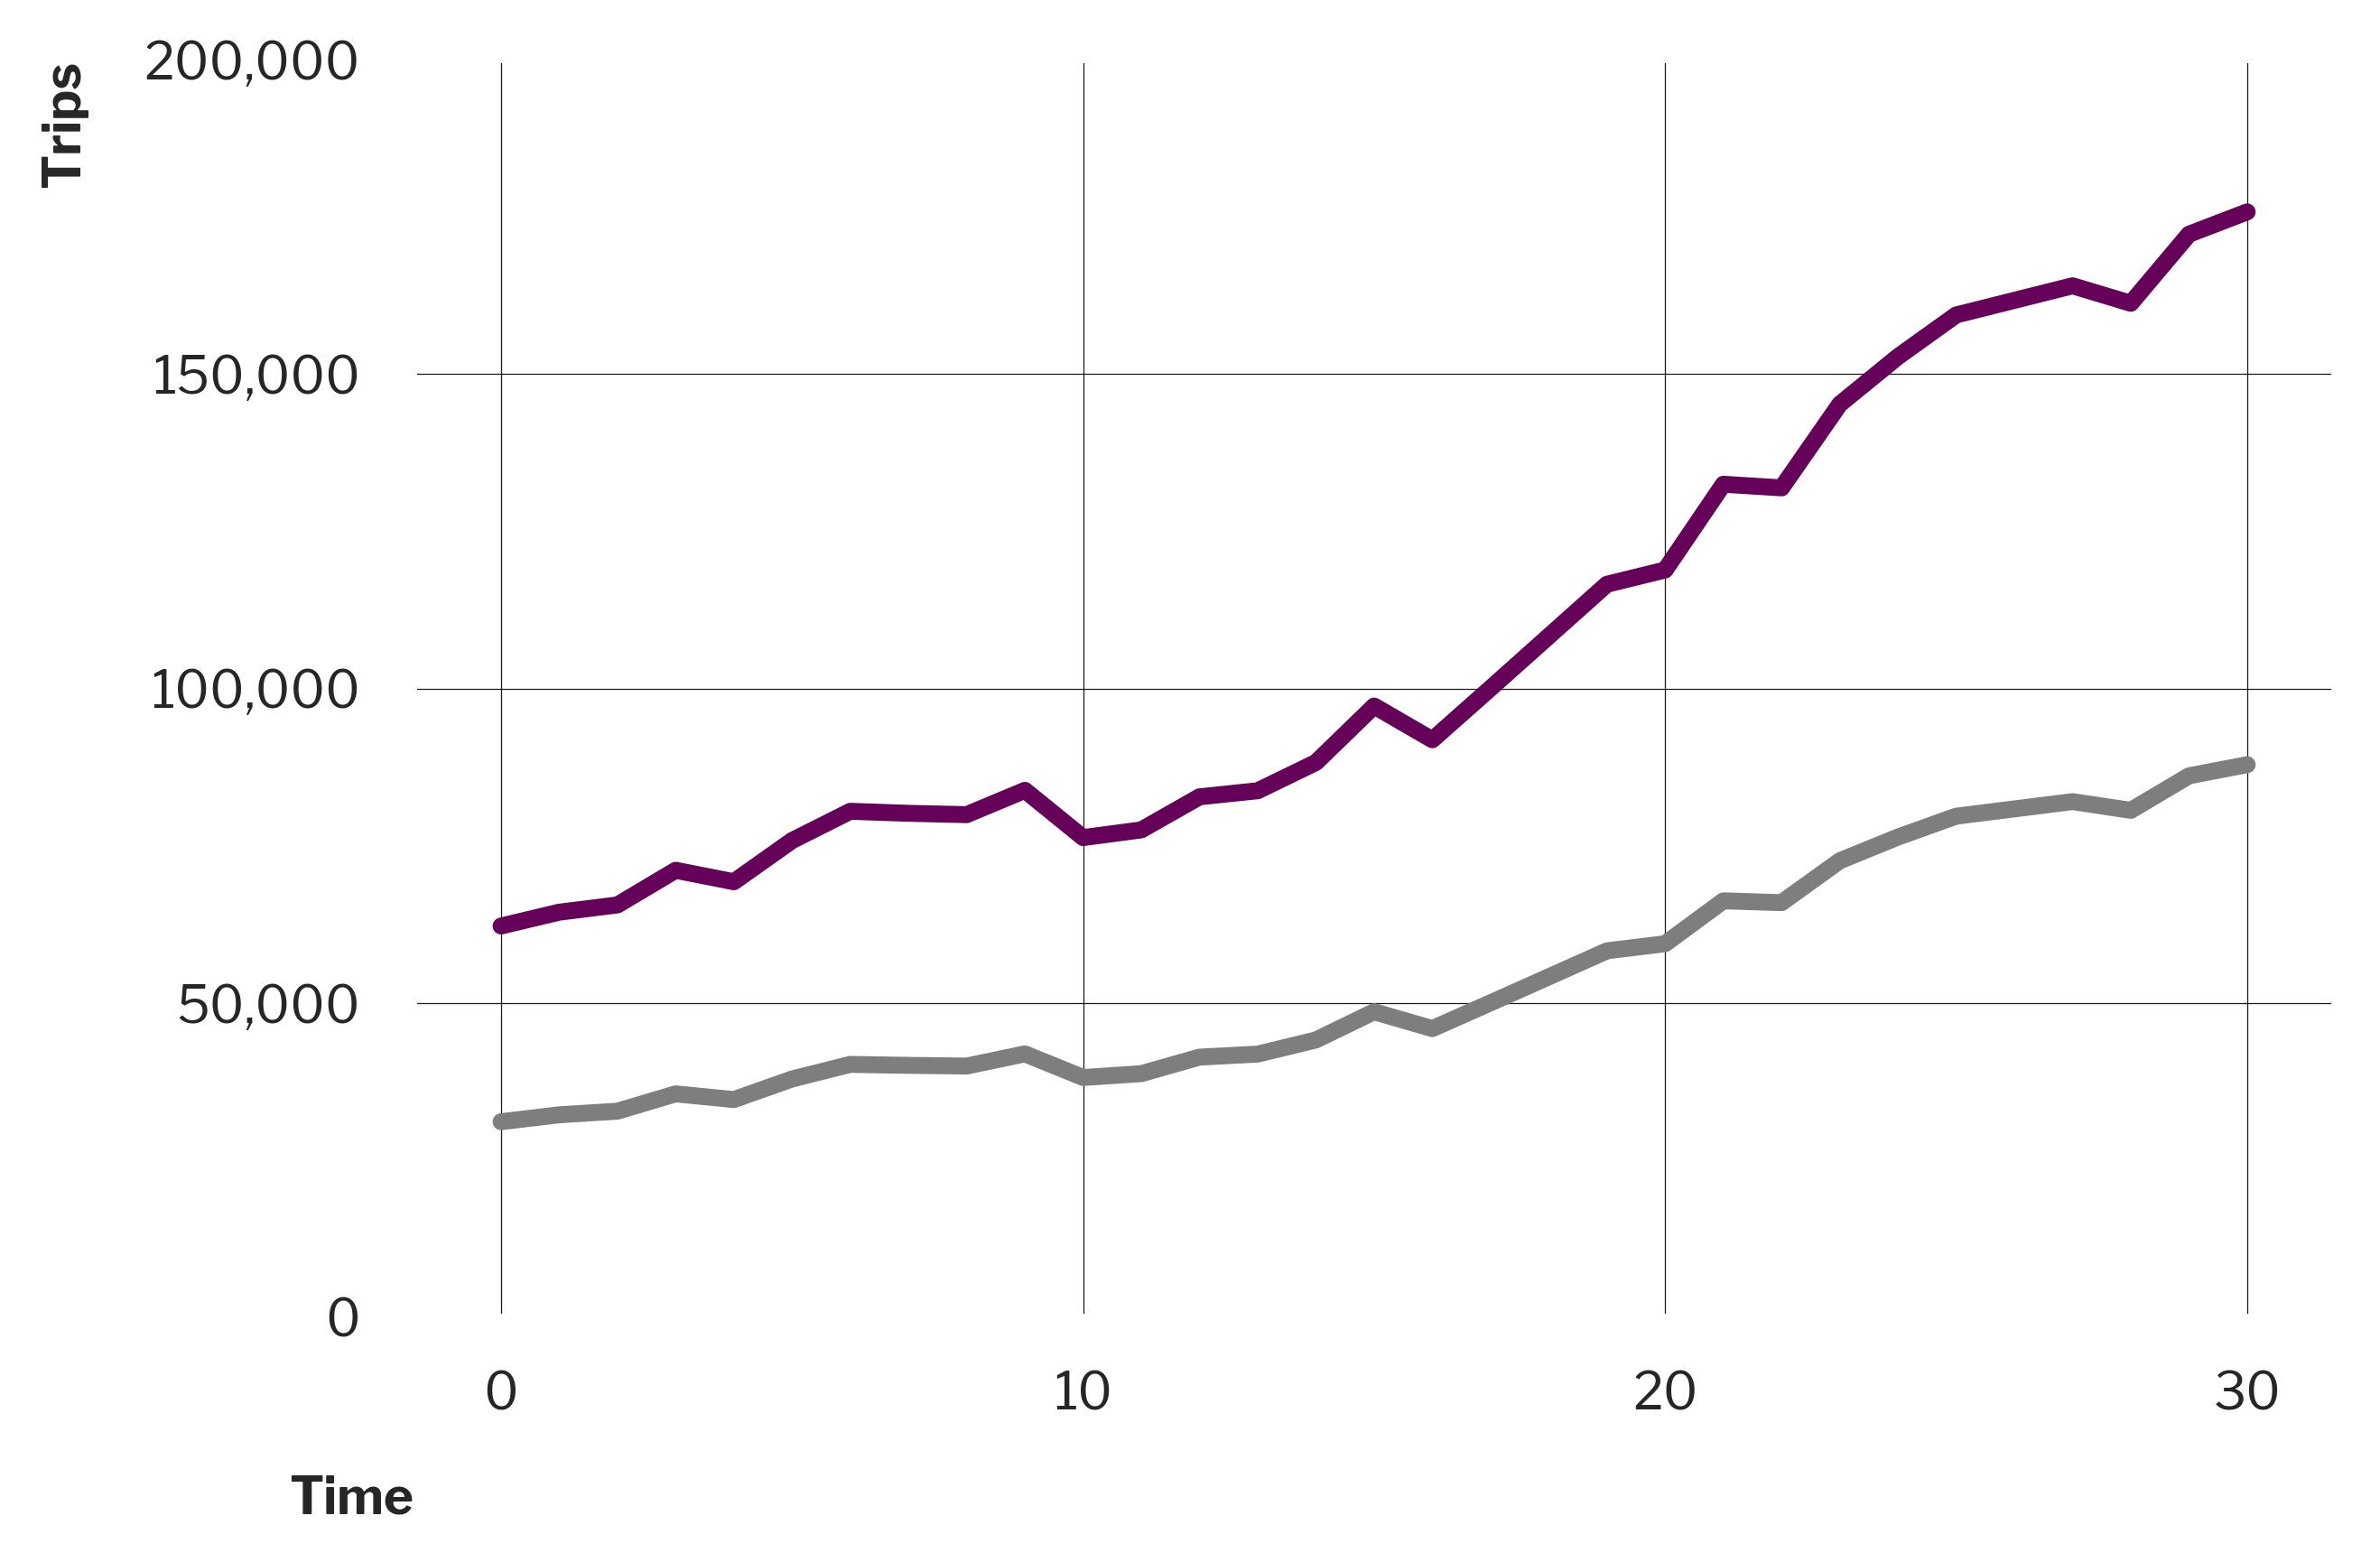

In [8]:
fig, ax = rick.charts.line_chart(total['count'], 'Trips', 'Time', baseline = total2['count'])

In [9]:
# fig.text(0.94, 0.96, '176,000', transform=ax.transAxes, wrap = True, fontsize=9, fontname = 'Libre Franklin',
#          verticalalignment='top', ha = 'center', bbox=props, color = purple)

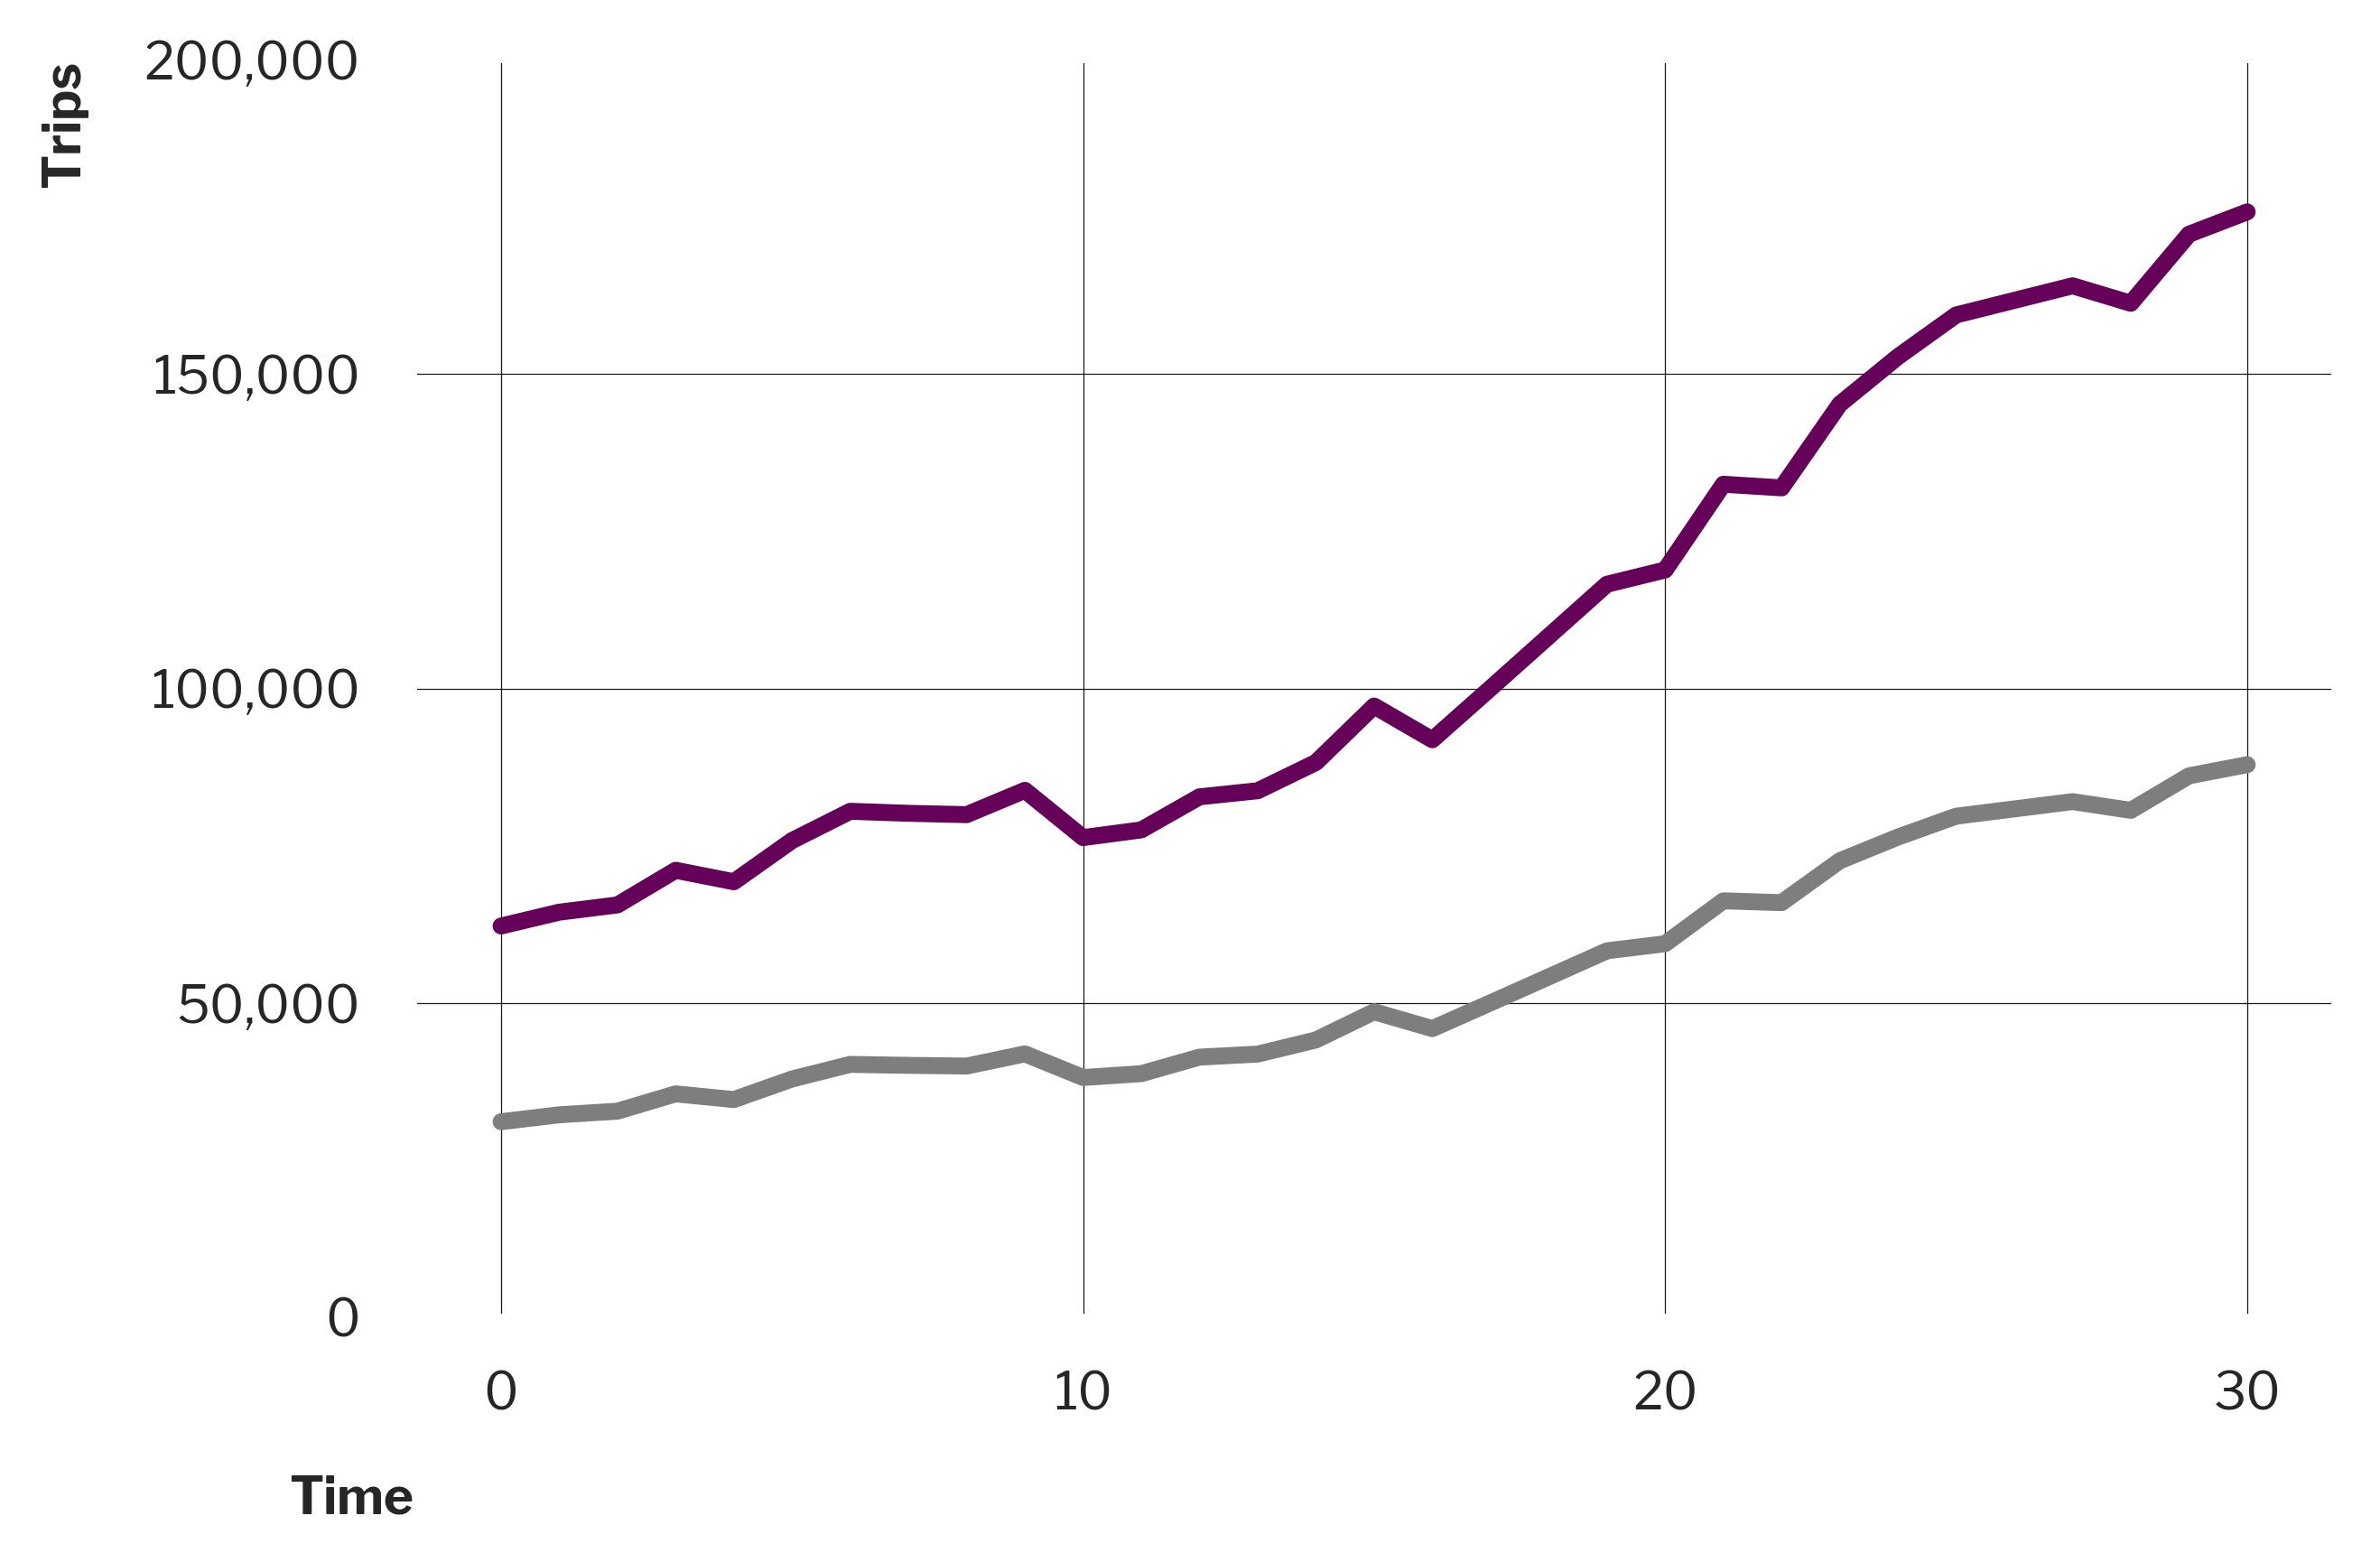

In [10]:
fig

In [11]:
query = '''

WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr

'''
count_18 = pandasql.read_sql(query,con)

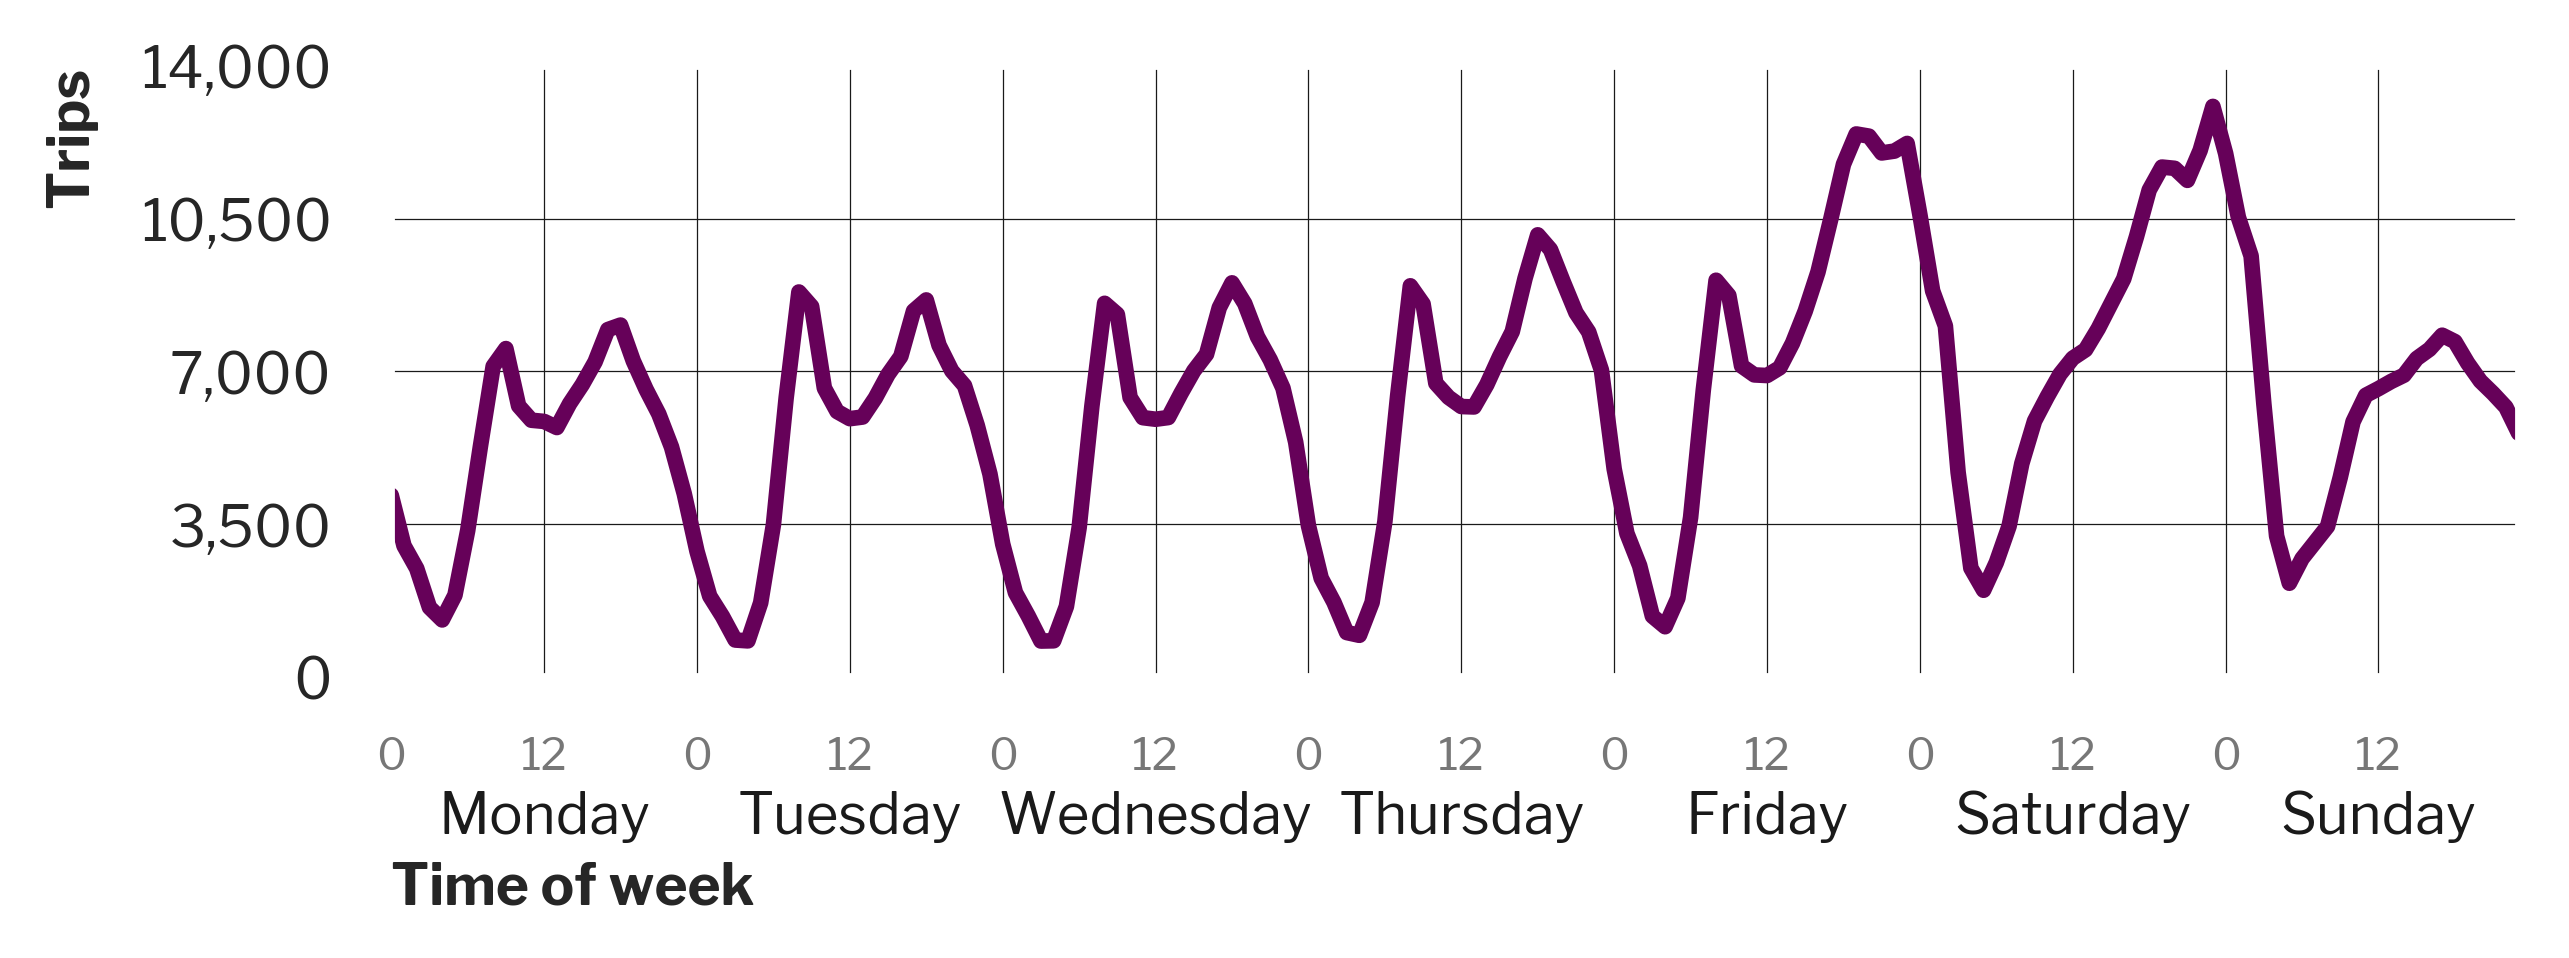

In [12]:
fig, ax = rick.charts.tow_chart(data = count_18['count'], ylab='Trips', ymax = 14000, yinc= 3500)

In [13]:
query = ''' 

WITH sum AS (

SELECT pickup_datetime, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr, area_name FROM ptc.trip_data_agg_ward_25
LEFT JOIN gis.ward_community_lookup ON pickup_ward2018 = area_short

WHERE pickup_datetime > '2016-09-30'
GROUP BY pickup_datetime, area_name
), collect AS (
SELECT area_name, avg(count) as count, mon, yr from sum
group by area_name,  mon, yr)

,tot1 AS (

SELECT area_name, avg(count) as count FROM collect
WHERE (yr =2016 AND mon IN (10))
GROUP BY area_name
), tot2 AS (

SELECT area_name, avg(count) as count FROM collect
WHERE (yr =2018 AND mon IN (9)) 
GROUP BY area_name
)
SELECT SPLIT_PART(area_name, 'Community', 1) as area_name,
b.count as count1, a.count as count2 FROM tot1 b
LEFT JOIN tot2 a USING (area_name)
ORDER BY count1 ASC
'''

district_cond = pandasql.read_sql(query, con)

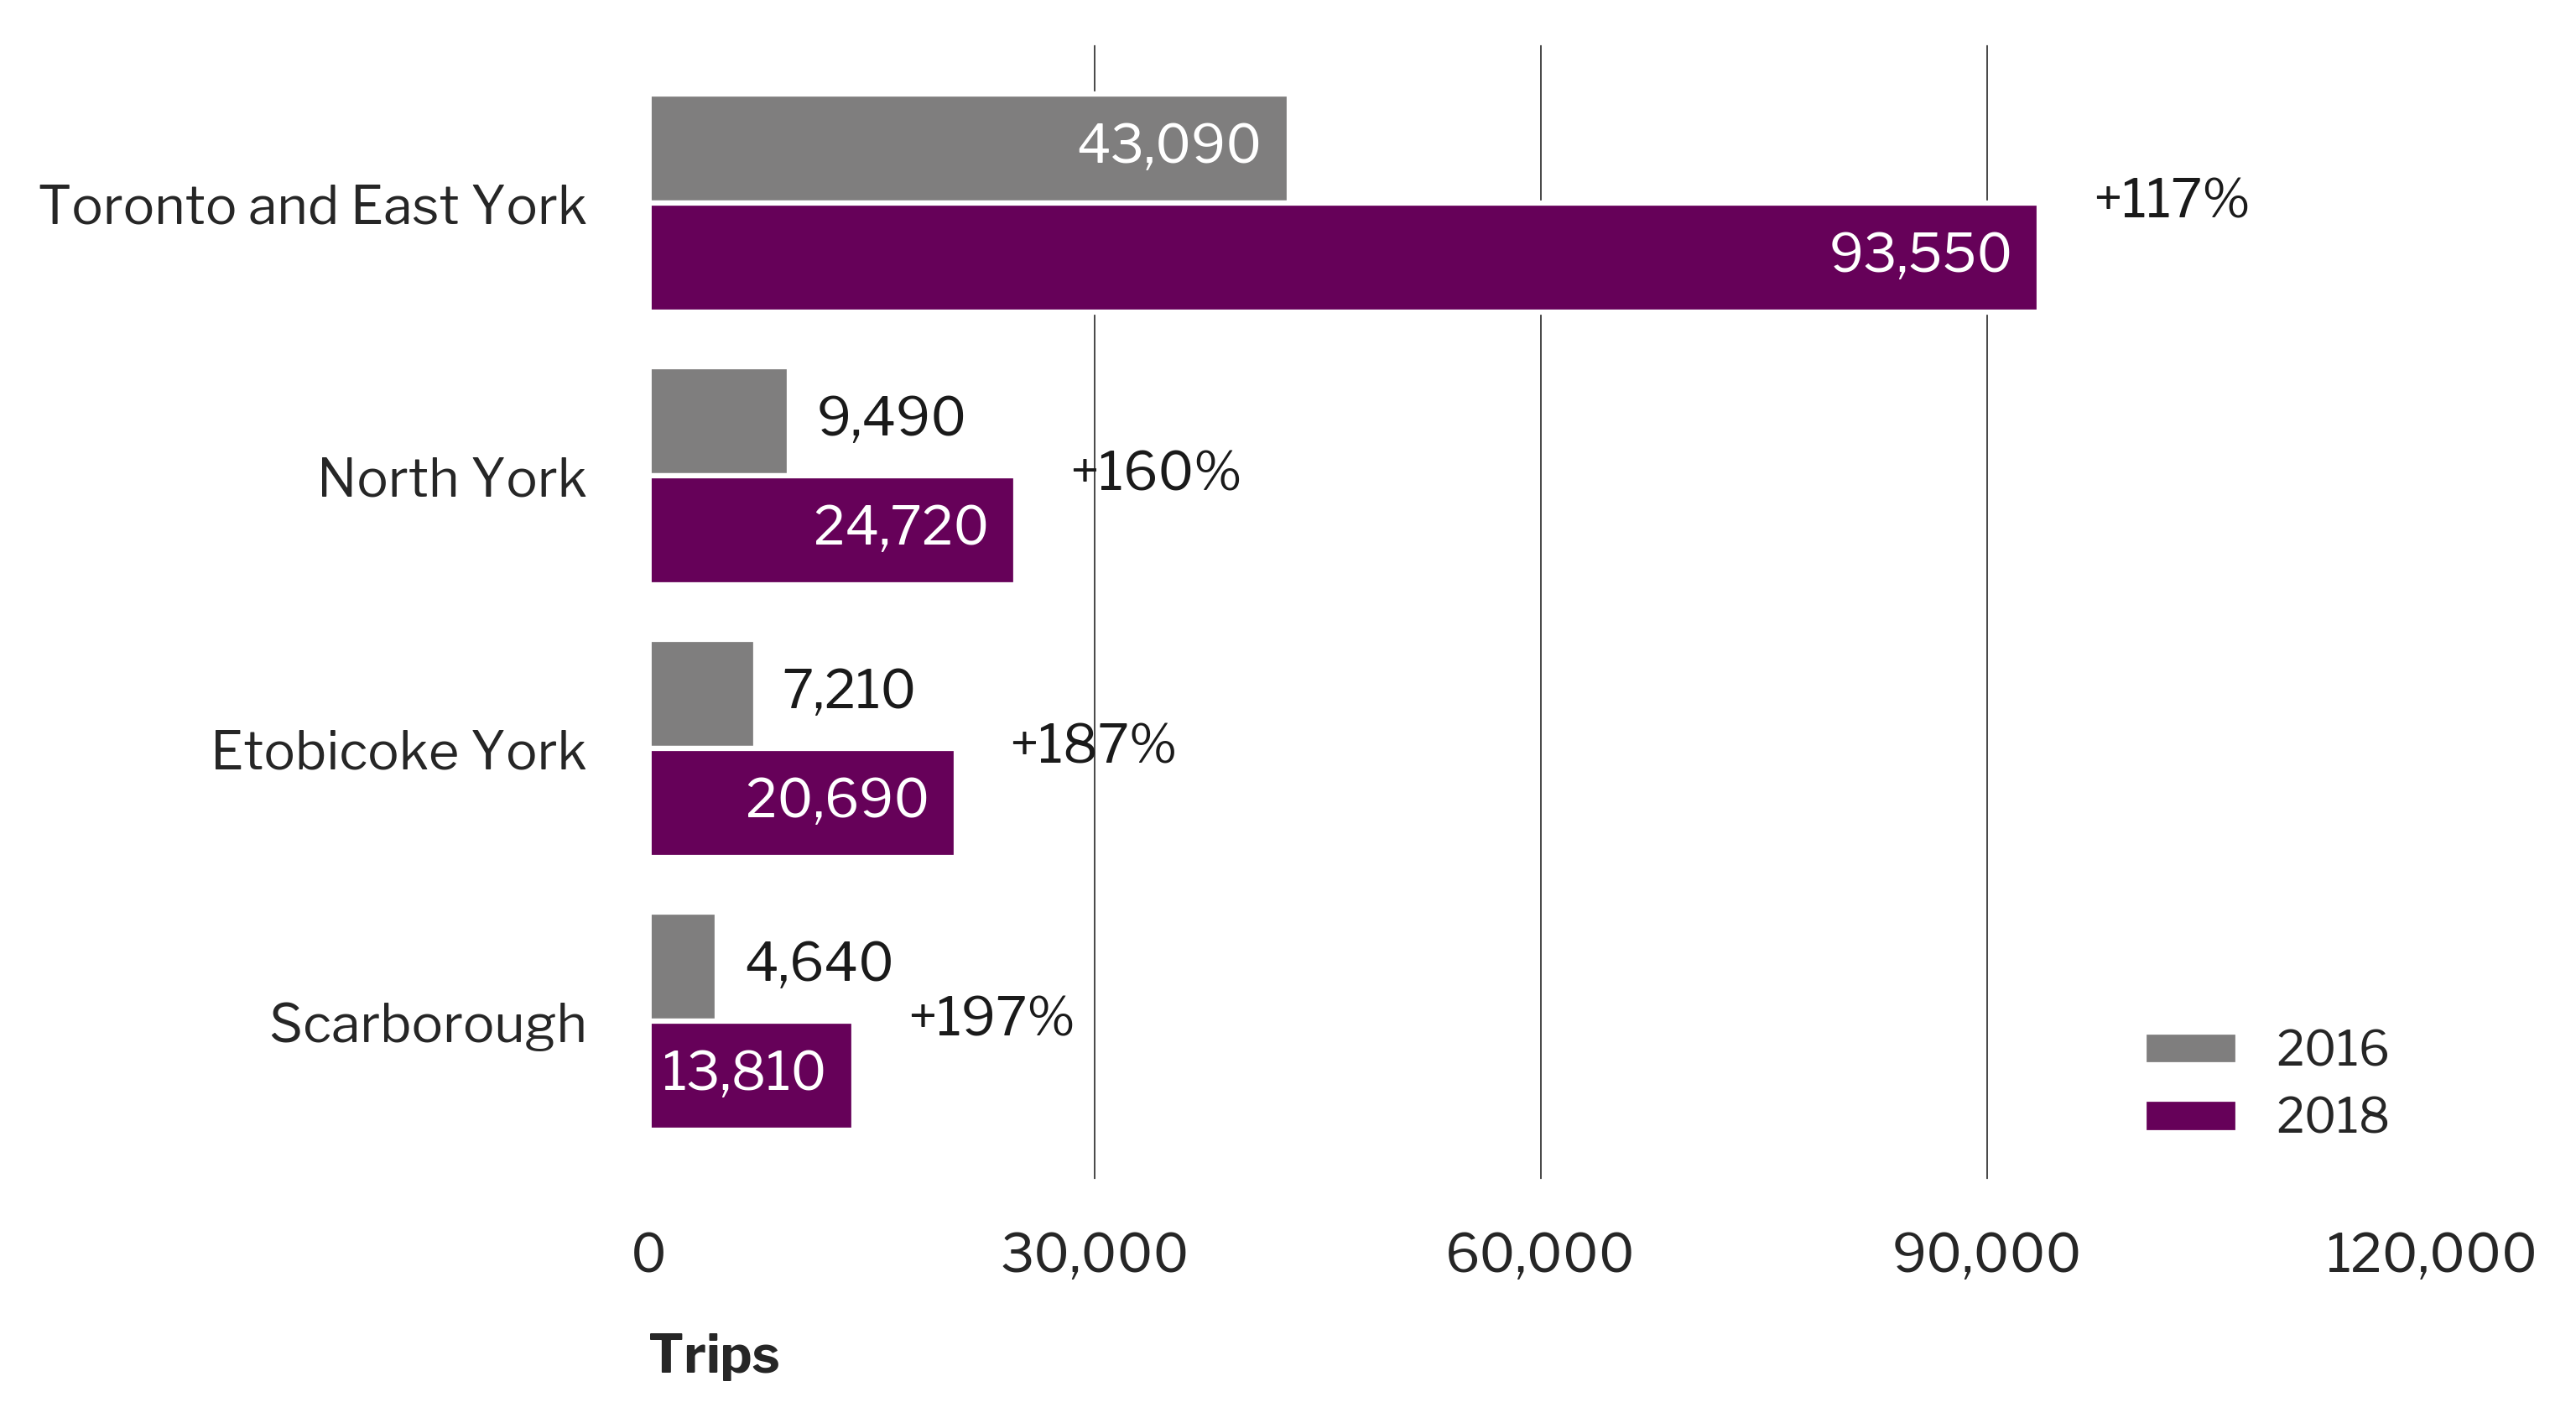

In [14]:
fig, ax = rick.charts.stacked_chart(district_cond, xlab = 'Trips', lab1 = '2016', lab2 = '2018', percent = True)

In [15]:
pass_data = {'cat': ['PTC','Taxi',  'Trip Making Population'],
        'TTC Pass': [22,16,16],
        }

transit_pass = pd.DataFrame(pass_data,columns= ['cat', 'TTC Pass'])
transit_pass  = transit_pass .reindex(index=transit_pass .index[::-1])

In [16]:
transit_pass

,cat,TTC Pass
2,Trip Making Population,16
1,Taxi,16
0,PTC,22


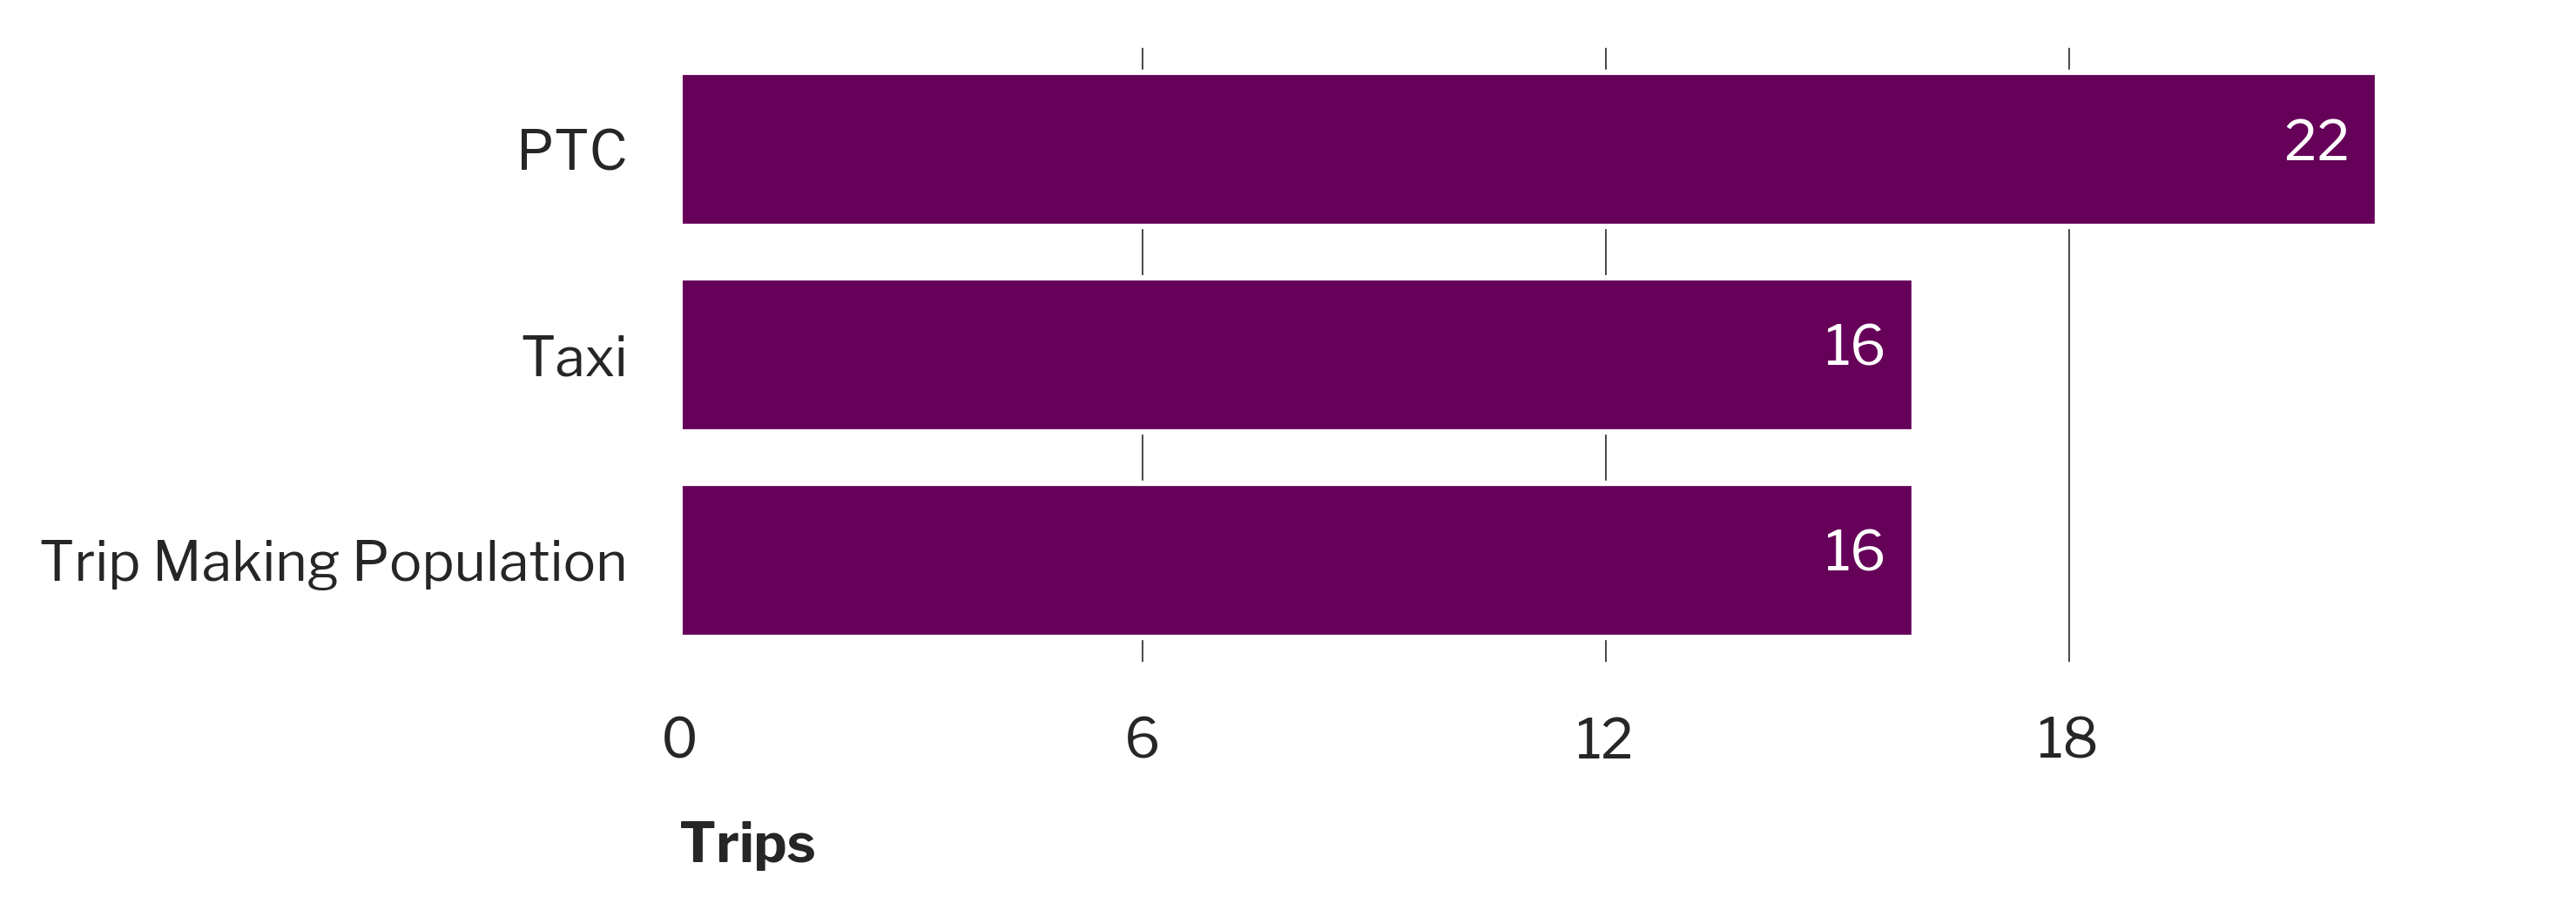

In [17]:
fig, ax = rick.charts.bar_chart(transit_pass, xlab='Trips')

In [18]:
transit_pass

,cat,TTC Pass
2,Trip Making Population,16
1,Taxi,16
0,PTC,22
